# Milestone 2

In [2]:
import os
import numpy as np
import pandas as pd
import yfinance as yf
from datetime import date, timedelta

# Config
SYMBOLS = [
    "^GSPC", "SPY",                # S&P 500 Index and SPY ETF
    "BTC-USD", "ETH-USD",          # crypto
    "^NSEI", "^NSEBANK",           # India indices
    "RELIANCE.NS", "TCS.NS",       # India stocks
    "EURUSD=X", "USDINR=X",        # FX
    "GC=F", "CL=F",                # commodities
    "^VIX"                         # volatility
]
TODAY = date.today()
START = (TODAY - timedelta(days=365*20 + 5*6)).isoformat()  # ~20y buffer for leap years
END = TODAY.isoformat()
INTERVAL = "1d"
SAVE_DIR = "data/raw"
os.makedirs(SAVE_DIR, exist_ok=True)

# Helper to download & save a single symbol
def download_symbol(symbol, start, end, interval="1d", auto_adjust=False):
    df = yf.download(
        symbol,
        start=start,
        end=end,
        interval=interval,
        auto_adjust=auto_adjust,
        progress=False,
        threads=False,
    )
    if df.empty:
        raise RuntimeError(f"No data returned for {symbol}. Check ticker or network.")
    # Ensure canonical column order if present
    cols = [c for c in ["Open", "High", "Low", "Close", "Adj Close", "Volume"] if c in df.columns]
    df = df[cols].copy()
    df.index.name = "Date"
    # Save CSV
    fname = os.path.join(SAVE_DIR, f"{symbol.replace('^','')}_{start}_to_{end}_{interval}.csv")
    df.to_csv(fname)
    info = {
        "symbol": symbol,
        "rows": len(df),
        "start": df.index.min().strftime("%Y-%m-%d"),
        "end": df.index.max().strftime("%Y-%m-%d"),
        "path": fname,
        "columns": cols,
    }
    return df, info

# Download datasets
results = []
for sym in SYMBOLS:
    df, meta = download_symbol(sym, START, END, INTERVAL, auto_adjust=False)
    results.append(meta)

# Report summary
print("Downloaded datasets:")
for r in results:
    print(f" - {r['symbol']:>5} | {r['rows']:>5} rows | {r['start']} → {r['end']} | {r['columns']} | {r['path']}")


Downloaded datasets:
 - ^GSPC |  5049 rows | 2005-09-12 → 2025-10-06 | ['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'] | data/raw/GSPC_2005-09-12_to_2025-10-07_1d.csv
 -   SPY |  5049 rows | 2005-09-12 → 2025-10-06 | ['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'] | data/raw/SPY_2005-09-12_to_2025-10-07_1d.csv
 - BTC-USD |  4037 rows | 2014-09-17 → 2025-10-05 | ['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'] | data/raw/BTC-USD_2005-09-12_to_2025-10-07_1d.csv
 - ETH-USD |  2888 rows | 2017-11-09 → 2025-10-05 | ['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'] | data/raw/ETH-USD_2005-09-12_to_2025-10-07_1d.csv
 - ^NSEI |  4428 rows | 2007-09-17 → 2025-10-06 | ['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'] | data/raw/NSEI_2005-09-12_to_2025-10-07_1d.csv
 - ^NSEBANK |  4153 rows | 2007-09-17 → 2025-10-06 | ['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'] | data/raw/NSEBANK_2005-09-12_to_2025-10-07_1d.csv
 - RELIANCE.NS |  4952 rows | 2005-09-12

In [3]:
import json

RAW_DIR   = "data/raw"
PROC_DIR  = "data/processed"
SPLIT_DIR = "data/splits"
os.makedirs(PROC_DIR, exist_ok=True)
os.makedirs(SPLIT_DIR, exist_ok=True)

# ---------- Find raw files ----------
def find_latest_raw(prefix: str) -> str:
    files = [f for f in os.listdir(RAW_DIR) if f.startswith(prefix + "_") and f.endswith(".csv")]
    if not files:
        raise FileNotFoundError(f"No raw CSV found for prefix '{prefix}' in {RAW_DIR}")
    files.sort()
    return os.path.join(RAW_DIR, files[-1])

gspc_raw = find_latest_raw("GSPC")
spy_raw  = find_latest_raw("SPY")
print("Found raw files:\n -", gspc_raw, "\n -", spy_raw)

# ---------- loader ----------
def load_yf_raw(path: str) -> pd.DataFrame:
    """
    Load Yahoo CSV robustly.
    Cases:
      A) Normal pandas/yfinance CSV with 'Date' column or index
      B) Multi-row header variant with lines like:
         Price,Open,High,Low,Close,Adj Close,Volume
         Ticker,^GSPC,^GSPC,^GSPC,^GSPC,^GSPC,^GSPC
         Date,,,,,,
         2005-09-12, ... 
    Returns a DataFrame indexed by DatetimeIndex with canonical columns.
    """
    # Try the simple case first
    try:
        df = pd.read_csv(path)
        if "Date" in df.columns:
            df["Date"] = pd.to_datetime(df["Date"], errors="coerce")
            df = df.set_index("Date").sort_index()
        else:
            df = pd.read_csv(path, index_col=0)
            df.index = pd.to_datetime(df.index, errors="coerce")
            df = df.sort_index()
        # If this worked and we have OHLCV columns, return
        if any(c in df.columns for c in ["Open","High","Low","Close","Adj Close","Volume"]):
            pass
        else:
            raise ValueError("Canonical OHLCV not detected; try fallback.")
        # Drop rows with invalid dates
        df = df[~df.index.isna()]
        # Coerce numeric
        for c in df.columns:
            df[c] = pd.to_numeric(df[c], errors="coerce")
        # Keep canonical columns if present
        cols = [c for c in ["Open","High","Low","Close","Adj Close","Volume"] if c in df.columns]
        return df[cols].dropna(how="all")
    except Exception:
        # Fallback: parse multi-row header variant
        raw = pd.read_csv(path, header=None)
        # Find the row where first cell is 'Date'
        header_rows = np.where(raw.iloc[:,0].astype(str).str.strip() == "Date")[0]
        if len(header_rows) == 0:
            raise ValueError(f"Could not locate 'Date' header row in {path}")
        hdr_idx = int(header_rows[0])
        header = raw.iloc[hdr_idx].tolist()
        body   = raw.iloc[hdr_idx+1:].copy()
        body.columns = header
        # Parse Date
        body["Date"] = pd.to_datetime(body["Date"], errors="coerce")
        body = body.set_index("Date").sort_index()
        # Coerce numeric
        for c in body.columns:
            body[c] = pd.to_numeric(body[c], errors="coerce")
        # Canonical columns (drop duplicate "Price" if present)
        cols = [c for c in ["Open","High","Low","Close","Adj Close","Volume"] if c in body.columns]
        return body[cols].dropna(how="all")

# ---------- Feature builder ----------
def compute_features(df: pd.DataFrame, symbol: str, rsi_window: int = 14) -> pd.DataFrame:
    """
    Features u_t using Adj Close if present, else Close.
    Creates forward-return targets for h=1,5,20 days.
    """
    out = df.copy()
    price_col = "Adj Close" if "Adj Close" in out.columns else "Close"
    out = out.rename(columns={price_col: "PX"})
    # log returns
    out["ret_1"] = np.log(out["PX"]).diff()
    # lagged returns (cumulative)
    out["ret_2"] = out["ret_1"].shift(1).rolling(2).sum()
    out["ret_5"] = out["ret_1"].shift(1).rolling(5).sum()
    # realized vol (20d, annualized)
    out["vol_20"] = out["ret_1"].rolling(20).std() * np.sqrt(252.0)
    # moving averages + gap
    out["ma_10"] = out["PX"].rolling(10).mean()
    out["ma_20"] = out["PX"].rolling(20).mean()
    out["ma_gap"] = out["PX"] / out["ma_20"] - 1.0
    # RSI(14)
    delta = out["PX"].diff()
    gain = delta.clip(lower=0).rolling(rsi_window).mean()
    loss = (-delta.clip(upper=0)).rolling(rsi_window).mean()
    rs = gain / loss.replace(0, np.nan)
    out["rsi_14"] = 100.0 - (100.0 / (1.0 + rs))
    # Volume z-score (60d)
    if "Volume" in out.columns:
        out["vol_z"] = (out["Volume"] - out["Volume"].rolling(60).mean()) / out["Volume"].rolling(60).std()
    else:
        out["vol_z"] = np.nan
    # Day-of-week
    out["dow"] = out.index.dayofweek
    # Forward targets
    out["target_h1"]  = out["ret_1"].shift(-1)
    out["target_h5"]  = out["ret_1"].rolling(5).sum().shift(-5)
    out["target_h20"] = out["ret_1"].rolling(20).sum().shift(-20)
    # Clean
    out = out.dropna().copy()
    out.insert(0, "Symbol", symbol)
    return out

# ---------- Build and save processed ----------
def process_and_save(raw_path: str, symbol: str) -> str:
    raw = load_yf_raw(raw_path)
    feats = compute_features(raw, symbol)
    out_path = os.path.join(PROC_DIR, f"{symbol}_features.csv")
    feats.to_csv(out_path, index=True)
    print(f"Saved {symbol} features: {out_path} | rows={len(feats)} | {feats.index.min().date()} → {feats.index.max().date()}")
    return out_path

gspc_proc = process_and_save(gspc_raw, "GSPC")
spy_proc  = process_and_save(spy_raw,  "SPY")

# ---------- Build walk-forward splits on date intersection ----------
def read_proc(path: str) -> pd.DataFrame:
    df = pd.read_csv(path)
    if "Date" in df.columns:
        df["Date"] = pd.to_datetime(df["Date"], errors="coerce")
        df = df.set_index("Date").sort_index()
    else:
        df = pd.read_csv(path, index_col=0)
        df.index = pd.to_datetime(df.index, errors="coerce")
        df = df.sort_index()
    df = df[~df.index.isna()]
    return df

gspc = read_proc(gspc_proc)
spy  = read_proc(spy_proc)

TRAIN_DAYS = 252 * 10  # ~10y
TEST_DAYS  = 252       # ~1y
STEP_DAYS  = 252       # slide ~1y

common_idx = gspc.index.intersection(spy.index).sort_values()
folds = []
start_ix = 0
while True:
    tr_start = start_ix
    tr_end   = tr_start + TRAIN_DAYS
    te_end   = tr_end + TEST_DAYS
    if te_end > len(common_idx):
        break
    folds.append({
        "train": {"start": common_idx[tr_start].strftime("%Y-%m-%d"),
                  "end":   common_idx[tr_end - 1].strftime("%Y-%m-%d")},
        "test":  {"start": common_idx[tr_end].strftime("%Y-%m-%d"),
                  "end":   common_idx[te_end - 1].strftime("%Y-%m-%d")},
        "details": {"train_days": TRAIN_DAYS, "test_days": TEST_DAYS}
    })
    start_ix += STEP_DAYS

splits_path = os.path.join(SPLIT_DIR, "splits.json")
with open(splits_path, "w") as f:
    json.dump({
        "index": "intersection(GSPC,SPY)",
        "train_days": TRAIN_DAYS,
        "test_days": TEST_DAYS,
        "step_days": STEP_DAYS,
        "folds": folds
    }, f, indent=2)

print(f"\nWalk-forward splits: {len(folds)} folds → {splits_path}")
if folds:
    print("Example fold[0]:", folds[0])


Found raw files:
 - data/raw/GSPC_2005-09-12_to_2025-10-07_1d.csv 
 - data/raw/SPY_2005-09-12_to_2025-10-07_1d.csv
Saved GSPC features: data/processed/GSPC_features.csv | rows=4970 | 2005-12-05 → 2025-09-08
Saved SPY features: data/processed/SPY_features.csv | rows=4969 | 2005-12-05 → 2025-09-08

Walk-forward splits: 9 folds → data/splits/splits.json
Example fold[0]: {'train': {'start': '2005-12-05', 'end': '2015-12-09'}, 'test': {'start': '2015-12-10', 'end': '2016-12-08'}, 'details': {'train_days': 2520, 'test_days': 252}}


/var/folders/61/fq6z9g8s18z74y82bjsdbr_m0000gn/T/ipykernel_23855/3766742864.py:42: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df.index = pd.to_datetime(df.index, errors="coerce")
/var/folders/61/fq6z9g8s18z74y82bjsdbr_m0000gn/T/ipykernel_23855/3766742864.py:42: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df.index = pd.to_datetime(df.index, errors="coerce")


In [4]:
from sklearn.preprocessing import StandardScaler

PROC_DIR  = "data/processed"
SPLIT_DIR = "data/splits"

# ---------- Load processed datasets ----------
def read_proc(path: str) -> pd.DataFrame:
    df = pd.read_csv(path)
    if "Date" in df.columns:
        df["Date"] = pd.to_datetime(df["Date"], errors="coerce")
        df = df.set_index("Date").sort_index()
    else:
        df = pd.read_csv(path, index_col=0)
        df.index = pd.to_datetime(df.index, errors="coerce")
        df = df.sort_index()
    return df[~df.index.isna()]

gspc = read_proc(os.path.join(PROC_DIR, "GSPC_features.csv"))
spy  = read_proc(os.path.join(PROC_DIR, "SPY_features.csv"))

# Align on common dates
idx = gspc.index.intersection(spy.index).sort_values()
gspc = gspc.loc[idx]
spy  = spy.loc[idx]

print("=== Quick EDA ===")
for sym, df in [("GSPC", gspc), ("SPY", spy)]:
    print(f"{sym}: rows={len(df)}, cols={len(df.columns)}, "
          f"range={df.index.min().date()} → {df.index.max().date()}, "
          f"NaN frac={df.isna().mean().mean():.4f}")

# ---------- Feature / target schema ----------
# Keep Symbol for bookkeeping but don't scale it. We'll drop it from model inputs later.
TARGET_COLS = ["target_h1", "target_h5", "target_h20"]
# Choose features u_t (exclude raw OHLCV and targets)
FEATURE_COLS = [
    "ret_1","ret_2","ret_5",
    "vol_20","ma_10","ma_20","ma_gap",
    "rsi_14","vol_z","dow"
]
# Sanity check
missing_feats = [c for c in FEATURE_COLS if c not in gspc.columns or c not in spy.columns]
if missing_feats:
    raise ValueError(f"Missing expected features: {missing_feats}")

# ---------- Load split plan ----------
with open(os.path.join(SPLIT_DIR, "splits.json"), "r") as f:
    split_plan = json.load(f)

folds = split_plan["folds"]
print(f"\nMaterializing {len(folds)} folds with leakage-safe scalers...")

def materialize_fold(k: int, df_left: pd.DataFrame, df_right: pd.DataFrame, save_dir: str):
    """Join two symbols side-by-side (optional), or just use one (here: SPY primary)."""
    # For this milestone, we’ll use SPY as the modeling dataset; GSPC can be auxiliary.
    # If you want a combined feature space, you could prefix and concat.
    fold = folds[k]
    tr_s, tr_e = fold["train"]["start"], fold["train"]["end"]
    te_s, te_e = fold["test"]["start"],  fold["test"]["end"]

    # Slice SPY (primary)
    tr = df_right.loc[tr_s:tr_e].copy()
    te = df_right.loc[te_s:te_e].copy()

    # Eject rows with missing targets (at edges due to shifting)
    tr = tr.dropna(subset=TARGET_COLS)
    te = te.dropna(subset=TARGET_COLS)

    # Fit scaler ONLY on train features
    scaler = StandardScaler()
    tr_X = scaler.fit_transform(tr[FEATURE_COLS].values)
    te_X = scaler.transform(te[FEATURE_COLS].values)

    # Build output frames (scaled features + unscaled targets + Date index)
    tr_out = pd.DataFrame(tr_X, index=tr.index, columns=[f"z_{c}" for c in FEATURE_COLS])
    te_out = pd.DataFrame(te_X, index=te.index, columns=[f"z_{c}" for c in FEATURE_COLS])

    # Attach targets and optional bookkeeping columns
    for c in TARGET_COLS:
        tr_out[c] = tr[c].values
        te_out[c] = te[c].values
    tr_out["Symbol"] = tr["Symbol"].values
    te_out["Symbol"] = te["Symbol"].values

    # Save fold
    os.makedirs(save_dir, exist_ok=True)
    tr_out.to_csv(os.path.join(save_dir, "train.csv"))
    te_out.to_csv(os.path.join(save_dir, "test.csv"))

    # Save scaler params for transparency (mean/scale per feature)
    scaler_meta = {
        "features": FEATURE_COLS,
        "mean": scaler.mean_.tolist(),
        "scale": scaler.scale_.tolist(),
        "train_start": tr_s, "train_end": tr_e,
        "test_start": te_s,  "test_end": te_e
    }
    with open(os.path.join(save_dir, "scaler.json"), "w") as f:
        json.dump(scaler_meta, f, indent=2)

    return {
        "k": k,
        "train_rows": len(tr_out),
        "test_rows": len(te_out),
        "train_range": (tr_s, tr_e),
        "test_range":  (te_s, te_e)
    }

# ---------- Run all folds ----------
materialized = []
for k in range(len(folds)):
    fold_dir = os.path.join(SPLIT_DIR, f"fold_{k}")
    info = materialize_fold(k, gspc, spy, fold_dir)
    materialized.append(info)
    print(f"Fold {k}: train={info['train_rows']:>4} rows, test={info['test_rows']:>4} rows | "
          f"{info['train_range'][0]}→{info['train_range'][1]} | {info['test_range'][0]}→{info['test_range'][1]}")

print("\nDone. Example paths:")
if materialized:
    print(" -", os.path.join(SPLIT_DIR, "fold_0", "train.csv"))
    print(" -", os.path.join(SPLIT_DIR, "fold_0", "test.csv"))


=== Quick EDA ===
GSPC: rows=4969, cols=20, range=2005-12-05 → 2025-09-08, NaN frac=0.0000
SPY: rows=4969, cols=20, range=2005-12-05 → 2025-09-08, NaN frac=0.0000

Materializing 9 folds with leakage-safe scalers...
Fold 0: train=2520 rows, test= 252 rows | 2005-12-05→2015-12-09 | 2015-12-10→2016-12-08
Fold 1: train=2520 rows, test= 252 rows | 2006-12-05→2016-12-08 | 2016-12-09→2017-12-08
Fold 2: train=2520 rows, test= 252 rows | 2007-12-06→2017-12-08 | 2017-12-11→2018-12-11
Fold 3: train=2520 rows, test= 252 rows | 2008-12-05→2018-12-11 | 2018-12-12→2019-12-11
Fold 4: train=2520 rows, test= 252 rows | 2009-12-07→2019-12-11 | 2019-12-12→2020-12-10
Fold 5: train=2520 rows, test= 252 rows | 2010-12-08→2020-12-10 | 2020-12-11→2021-12-10
Fold 6: train=2520 rows, test= 252 rows | 2011-12-07→2021-12-10 | 2021-12-13→2022-12-12
Fold 7: train=2520 rows, test= 252 rows | 2012-12-10→2022-12-12 | 2022-12-13→2023-12-13
Fold 8: train=2520 rows, test= 252 rows | 2013-12-10→2023-12-13 | 2023-12-14→2024

In [5]:
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, mean_absolute_error

SPLIT_DIR = "data/splits"
FOLD = 0
fold_dir = os.path.join(SPLIT_DIR, f"fold_{FOLD}")

train_path = os.path.join(fold_dir, "train.csv")
test_path  = os.path.join(fold_dir, "test.csv")
assert os.path.exists(train_path) and os.path.exists(test_path), "Missing fold_0 csvs."

train = pd.read_csv(train_path, index_col=0, parse_dates=True)
test  = pd.read_csv(test_path,  index_col=0, parse_dates=True)

# Features and targets
FEATURE_COLS = [c for c in train.columns if c.startswith("z_")]
TARGETS = ["target_h1", "target_h5", "target_h20"]  # multi-horizon

X_tr, X_te = train[FEATURE_COLS].values, test[FEATURE_COLS].values
metrics = []

pred_df = pd.DataFrame(index=test.index)

for tgt in TARGETS:
    y_tr = train[tgt].values
    y_te = test[tgt].values

    # Simple Ridge readout
    model = Ridge(alpha=1.0, fit_intercept=True, random_state=0)
    model.fit(X_tr, y_tr)
    y_hat = model.predict(X_te)

    rmse = mean_squared_error(y_te, y_hat, squared=False)
    mae  = mean_absolute_error(y_te, y_hat)

    # Directional accuracy (sign agreement)
    dir_acc = np.mean(np.sign(y_hat) == np.sign(y_te))

    metrics.append({"target": tgt, "rmse": rmse, "mae": mae, "dir_acc": dir_acc})

    pred_df[f"pred_{tgt}"] = y_hat
    pred_df[f"true_{tgt}"] = y_te

# Save predictions
out_pred_path = os.path.join(fold_dir, "preds_baseline.csv")
pred_df.to_csv(out_pred_path)

# Print summary
print("=== Fold 0 — Ridge Readout Baseline ===")
print(f"Train rows: {len(train):,} | Test rows: {len(test):,}")
print(f"Features: {len(FEATURE_COLS)} → {FEATURE_COLS[:5]} ...")
print("\nMetrics (test set):")
for m in metrics:
    print(f" - {m['target']:<10} RMSE={m['rmse']:.6f} | MAE={m['mae']:.6f} | DirAcc={m['dir_acc']:.3f}")

print(f"\nSaved predictions → {out_pred_path}")


=== Fold 0 — Ridge Readout Baseline ===
Train rows: 2,520 | Test rows: 252
Features: 10 → ['z_ret_1', 'z_ret_2', 'z_ret_5', 'z_vol_20', 'z_ma_10'] ...

Metrics (test set):
 - target_h1  RMSE=0.008599 | MAE=0.006228 | DirAcc=0.504
 - target_h5  RMSE=0.018104 | MAE=0.013711 | DirAcc=0.448
 - target_h20 RMSE=0.035407 | MAE=0.028105 | DirAcc=0.440

Saved predictions → data/splits/fold_0/preds_baseline.csv


/Users/pep/Projects/setup/env/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Users/pep/Projects/setup/env/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Users/pep/Projects/setup/env/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


=== Test Metrics (Fold 0) ===
    target     rmse      mae        r2  dir_acc
 target_h1 0.008599 0.006228  0.000284 0.503968
 target_h5 0.018104 0.013711 -0.050412 0.448413
target_h20 0.035407 0.028105 -0.127060 0.440476

Residual summary (h=1):
count    252.000000
mean       0.000531
std        0.008599
min       -0.035014
25%       -0.002868
50%        0.000659
75%        0.005476
max        0.024792
dtype: float64


/Users/pep/Projects/setup/env/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Users/pep/Projects/setup/env/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Users/pep/Projects/setup/env/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


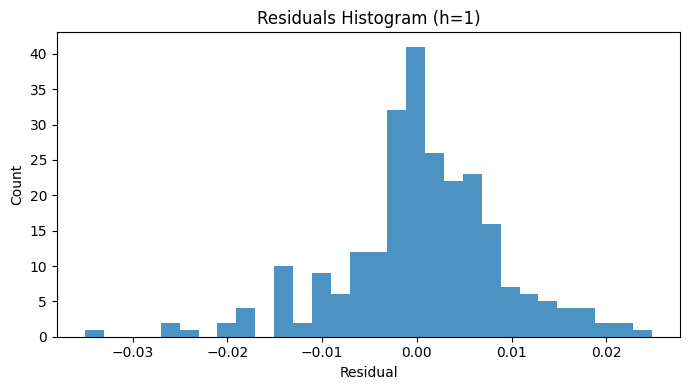

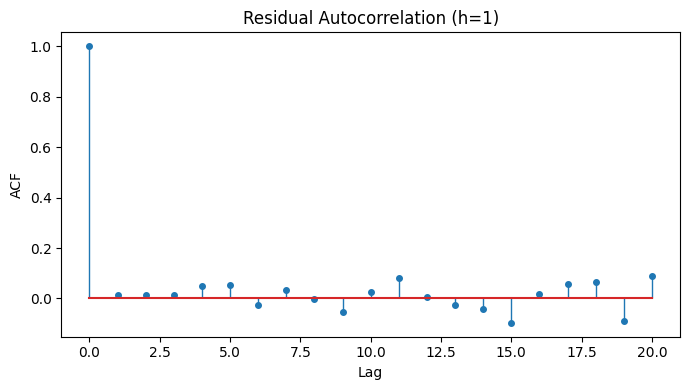


=== Simple Backtest (h=1) ===
Avg daily PnL: 0.000185
Vol (std):     0.008607
Sharpe:        0.341
Hit ratio:     0.504
Turnover:      0.679 trades/day


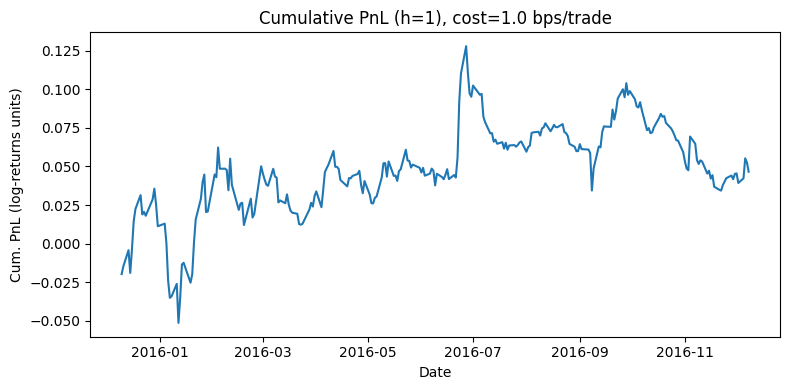


Top features by |Ridge coef| (h=1):
 feature      coef  abs_coef
 z_ret_1 -0.000924  0.000924
z_ma_gap -0.000897  0.000897
z_vol_20 -0.000635  0.000635
 z_ma_20 -0.000625  0.000625
 z_vol_z -0.000543  0.000543
 z_ret_5 -0.000441  0.000441
 z_ma_10  0.000375  0.000375
   z_dow -0.000345  0.000345
z_rsi_14  0.000227  0.000227
 z_ret_2 -0.000119  0.000119

Saved:
 - data/splits/fold_0/analysis_summary.csv
 - data/splits/fold_0/analysis_summary.json


In [6]:
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

SPLIT_DIR = "data/splits"
FOLD = 0
fold_dir = os.path.join(SPLIT_DIR, f"fold_{FOLD}")

train_path = os.path.join(fold_dir, "train.csv")
test_path  = os.path.join(fold_dir, "test.csv")
preds_path = os.path.join(fold_dir, "preds_baseline.csv")
scaler_path = os.path.join(fold_dir, "scaler.json")

assert os.path.exists(train_path) and os.path.exists(test_path) and os.path.exists(preds_path), "Missing fold files."

train = pd.read_csv(train_path, index_col=0, parse_dates=True)
test  = pd.read_csv(test_path,  index_col=0, parse_dates=True)
preds = pd.read_csv(preds_path, index_col=0, parse_dates=True)

# --- Metrics helper ---
def basic_metrics(y_true, y_pred):
    rmse = mean_squared_error(y_true, y_pred, squared=False)
    mae  = mean_absolute_error(y_true, y_pred)
    r2   = r2_score(y_true, y_pred)
    dir_acc = float(np.mean(np.sign(y_true) == np.sign(y_pred)))
    return {"rmse": rmse, "mae": mae, "r2": r2, "dir_acc": dir_acc}

targets = ["target_h1", "target_h5", "target_h20"]
metric_rows = []
for tgt in targets:
    y_true = preds[f"true_{tgt}"].values
    y_pred = preds[f"pred_{tgt}"].values
    row = {"target": tgt, **basic_metrics(y_true, y_pred)}
    metric_rows.append(row)

metrics_df = pd.DataFrame(metric_rows)
print("=== Test Metrics (Fold 0) ===")
print(metrics_df.to_string(index=False))

# --- Residual diagnostics (h=1) ---
tgt = "target_h1"
y_true = preds[f"true_{tgt}"].values
y_pred = preds[f"pred_{tgt}"].values
resid = y_true - y_pred

print("\nResidual summary (h=1):")
print(pd.Series(resid).describe())

# Plot: residual histogram
plt.figure(figsize=(7,4))
plt.hist(resid, bins=30, alpha=0.8)
plt.title("Residuals Histogram (h=1)")
plt.xlabel("Residual"); plt.ylabel("Count")
plt.tight_layout()
plt.show()

# Plot: residual autocorrelation (up to lag 20) — manual ACF
def acf(x, nlags=20):
    x = np.asarray(x)
    x = x - x.mean()
    denom = np.dot(x, x)
    ac = [1.0]
    for k in range(1, nlags+1):
        ac.append(np.dot(x[:-k], x[k:]) / denom if denom > 0 else np.nan)
    return np.array(ac)

lags = 20
acf_vals = acf(resid, nlags=lags)

plt.figure(figsize=(7,4))
try:
    # Newer/older Matplotlib: don't pass 'use_line_collection'
    markerline, stemlines, baseline = plt.stem(range(lags+1), acf_vals)
    plt.setp(stemlines, linewidth=1.0)
    plt.setp(markerline, markersize=4)
except TypeError:
    # Fallback: simple bar plot if stem signature is incompatible
    plt.bar(range(lags+1), acf_vals, width=0.6)

plt.title("Residual Autocorrelation (h=1)")
plt.xlabel("Lag")
plt.ylabel("ACF")
plt.tight_layout()
plt.show()

# --- Simple decision backtest (h=1) ---
# Strategy: position = sign(y_pred); daily pnl = position * y_true - cost_per_trade * |position_change|
# Note: returns are log-returns; this is a toy sanity check.
cost_per_trade = 0.0001  # 1 bp per trade
pos = np.sign(y_pred)
pos_change = np.abs(np.diff(pos, prepend=0))
pnl = pos * y_true - cost_per_trade * pos_change

# Aggregate stats
cum_pnl = pnl.cumsum()
ann_factor = np.sqrt(252.0)  # for Sharpe on daily data
sharpe = pnl.mean() / (pnl.std() + 1e-12) * ann_factor
hit_ratio = float(np.mean((pos * y_true) > 0))

print(f"\n=== Simple Backtest (h=1) ===")
print(f"Avg daily PnL: {pnl.mean():.6f}")
print(f"Vol (std):     {pnl.std():.6f}")
print(f"Sharpe:        {sharpe:.3f}")
print(f"Hit ratio:     {hit_ratio:.3f}")
print(f"Turnover:      {pos_change.mean():.3f} trades/day")

# Plot: cumulative PnL curve
plt.figure(figsize=(8,4))
plt.plot(preds.index, cum_pnl)
plt.title(f"Cumulative PnL (h=1), cost={cost_per_trade*1e4:.1f} bps/trade")
plt.xlabel("Date"); plt.ylabel("Cum. PnL (log-returns units)")
plt.tight_layout()
plt.show()

# --- Coefficient inspection (Ridge weights) ---
# We'll re-fit the very same Ridge readout on train (features z_*) and print top |coef| features.
from sklearn.linear_model import Ridge
FEATURE_COLS = [c for c in train.columns if c.startswith("z_")]
X_tr = train[FEATURE_COLS].values
y_tr = train["target_h1"].values

ridge = Ridge(alpha=1.0, fit_intercept=True, random_state=0)
ridge.fit(X_tr, y_tr)

coef_df = pd.DataFrame({
    "feature": FEATURE_COLS,
    "coef": ridge.coef_,
    "abs_coef": np.abs(ridge.coef_)
}).sort_values("abs_coef", ascending=False)

print("\nTop features by |Ridge coef| (h=1):")
print(coef_df.head(10).to_string(index=False))

# --- Save analysis summary ---
summary = {
    "metrics": metrics_df.round(6).to_dict(orient="records"),
    "backtest": {
        "avg_daily_pnl": float(np.round(pnl.mean(), 6)),
        "vol": float(np.round(pnl.std(), 6)),
        "sharpe": float(np.round(sharpe, 3)),
        "hit_ratio": float(np.round(hit_ratio, 3)),
        "turnover": float(np.round(pos_change.mean(), 3)),
        "cost_per_trade": cost_per_trade
    },
    "top_coef_h1": coef_df.head(10).to_dict(orient="records")
}
out_summary = os.path.join(fold_dir, "analysis_summary.csv")

# flatten summary (metrics only) to CSV for quick viewing; keep full JSON as well
pd.DataFrame(metrics_df).to_csv(out_summary, index=False)

import json
with open(os.path.join(fold_dir, "analysis_summary.json"), "w") as f:
    json.dump(summary, f, indent=2)

print(f"\nSaved:\n - {out_summary}\n - {os.path.join(fold_dir, 'analysis_summary.json')}")
